In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import vonmises, t

In [55]:
def run_simulations(n_exp = 50, pop_size=100, init = 0.1, n_gen = 5000, self_ref = True, meta_mutation_rate = 0.1, nlevels = 5, topk = 8, type = "instant"):
    """
        Initialize the parameters.

        Parameters:
        -----------
        n_exp : int, default=50
            The number of independent experiments performed.
        
        pop_size : int, default=100
            The number of individuals in the population

        init : float, default=0.1
            The initialization of meta-parameters.

        n_gen : int, default=5000
            Total number of generations.

        self_ref : bool, default=True
            Whether self-referential mutation rates are used (True) or not (False)

        meta_mutation_rate : float, default=0.1
            The (external) meta mutation rate. It is used only if self-referential mutations rates are not used (referential = False).

        nlevels : int, default=5
            Total number of levels, INCLUDING the solution level.

        topk : int, default=8
            The top-k parameter determining the number of top solutions that have children.

        type : str, default="instant"
            Determining how the mutations propagate - instantly ("instant") or in a delayed manner ("delayed)

        Returns:
        allbestfitnesses : np.array
            A np.array containing all of the best-of-generation fitnesses
        allbesties: np.array
            A np.array containing the best solution from every generation
        allsigmas: np.array
        A np.array containing the total history of solutions and mutation rates
        """

    allbestfitnesses = []
    allbesties = []
    allsigmas = []
    for j in range(n_exp):
        sigmas_history = []
        sigmas = init*np.ones((nlevels,pop_size))
        sigmas[-1,:] = 1000
        bestfitnesses = []
        besties = []
        sigmas_history.append(sigmas.copy())
        for i in range(n_gen-1):
            #fitnesses = np.abs(sigmas[-1,:]-np.ones(pop_size)*np.exp(-5*abs(i % 200 - 100) / 100))
            solutions = sigmas[-1,:]
            fitnesses = np.abs(solutions-np.zeros(pop_size))
            sort_indices = np.argsort(fitnesses)
            bestindex = sort_indices[0]
            bestfitnesses.append(fitnesses[bestindex])
            besties.append(sigmas[:,bestindex].copy())
            top_indices = sort_indices[:topk]
            other_indices = np.array([i for i in range(pop_size) if i not in top_indices])
            sampled_indices = np.random.choice(top_indices, size=len(other_indices), replace=True)
            sigmas[:,other_indices] = sigmas[:,sampled_indices]
            if type == "instant":
                if self_ref == True:
                    sigmas[0,:] += np.random.normal(0,abs(sigmas[0,:]))
                else:
                    sigmas[0,:] += np.random.normal(0,meta_mutation_rate)
                for k in range(1,nlevels,1): 
                    sigmas[k,:] += np.random.normal(0,abs(sigmas[k-1,:]))
            else:
                for k in range(nlevels-1,0,-1): 
                    sigmas[k,other_indices] += np.random.normal(0,abs(sigmas[k-1,other_indices]))
                if self_ref == True:
                    sigmas[0,other_indices] += np.random.normal(0,abs(sigmas[0,other_indices]))
                else:
                    sigmas[0,other_indices] += np.random.normal(0,meta_mutation_rate)
            sigmas[:-1,:] = abs(sigmas[:-1,:])
            sigmas_history.append(sigmas.copy())
        allbestfitnesses.append(bestfitnesses)
        allbesties.append(besties)
        allsigmas.append(sigmas_history)
    return np.array(allbestfitnesses), np.array(allbesties), np.array(allsigmas)

In [56]:
allbestfitnesses, allbesties, allsigmas = run_simulations(n_exp = 20, pop_size=100, init = 0.1, n_gen = 2000, self_ref = False, meta_mutation_rate = 0.001, nlevels = 6, topk = 8, type = "instant")

In [57]:
print("The mean best-of-generation fitness is: {}".format(np.mean(allbestfitnesses)))
print("The median best-of-generation fitness is: {}".format(np.median(allbestfitnesses)))

The mean best-of-generation fitness is: 8.38133558376111
The median best-of-generation fitness is: 6.173962041419436e-05


In [59]:
def plotter(type="mean",what="best",level=0):
    if type == "mean" and what == "best":
        plt.plot(np.mean(allbesties[:,:,-1-level], axis=0))
    elif type == "median" and what == "best":
        plt.plot(np.median(allbesties[:,:,-1-level], axis=0))
    elif type == "mean" and what == "all":
        plt.plot(np.mean(allsigmas[:,:,-1-level,:],axis=(0,2)))
    else:
        plt.plot(np.median(allsigmas[:,:,-1-level,:],axis=(0,2)))

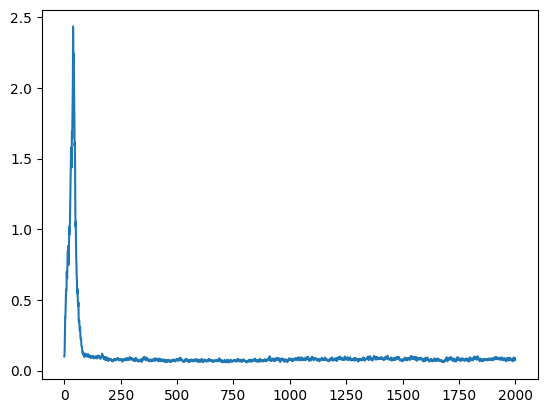

In [60]:
plotter("median","all",3)